## Evaluation for Semantic Similarity 

BBE is designed for greater readability than KJV, but ideally without losing significant semantic meaning. The hypothesis is that the semantic similarity between KJV and the text generated by the MVP model, as well as between KJV and the text generated by Gemma, will be at least as high as the similarity between KJV and BBE. This implies that MVP and Gemma can generate text with similar semantic fidelity to BBE's simplified style.

This notebook will statistically test this hypothesis.

### import packages

In [1]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from scipy.stats import wilcoxon
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_rows', None) 

### instantiate embedding model

In [3]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

In [4]:
# Function to compute embeddings for a column in the dataframe
def compute_embeddings(dataframe, column_name):
    sentences = dataframe[column_name].tolist()
    embeddings = model.encode(sentences)
    return embeddings

### read in data and compute embeddings for each text column 

In [5]:
bible_df = pd.read_csv('final_merged_test_df.csv')

In [6]:
embeddings_kjv = compute_embeddings(bible_df, 'KJV')
embeddings_bbe = compute_embeddings(bible_df, 'BBE')
embeddings_gemma = compute_embeddings(bible_df, 'gemma_bbe')
embeddings_mvp = compute_embeddings(bible_df, 'mvp_bbe')

bible_df['KJV_embed'] = [embedding for embedding in embeddings_kjv]
bible_df['BBE_embed'] = [embedding for embedding in embeddings_bbe]
bible_df['gemma_bbe_embed'] = [embedding for embedding in embeddings_gemma]
bible_df['mvp_bbe_embed'] = [embedding for embedding in embeddings_mvp]

### Calculate cosine similarity between pairs 
- A value of 1 represents maximum similarity (identical vectors).
- A value of 0 represents orthogonal vectors (no similarity).

In [7]:
bible_df['cosine_kjv_bbe'] = bible_df.apply(lambda row: 1 - cosine(row['KJV_embed'], row['BBE_embed']), axis=1)
bible_df['cosine_kjv_mvp'] = bible_df.apply(lambda row: 1 - cosine(row['KJV_embed'], row['mvp_bbe_embed']), axis=1)
bible_df['cosine_kjv_gemma'] = bible_df.apply(lambda row: 1 - cosine(row['KJV_embed'], row['gemma_bbe_embed']), axis=1)

### get summary statistics for each cosine similarity pair

In [8]:
print("Cosine Similarity Between KJV and BBE:")
print(bible_df['cosine_kjv_bbe'].describe())

print("Cosine Similarity Between KJV and MVP:")
print(bible_df['cosine_kjv_mvp'].describe())

print("Cosine Similarity Between KJV and Gemma:")
print(bible_df['cosine_kjv_gemma'].describe())

Cosine Similarity Between KJV and BBE:
count    78.000000
mean      0.835347
std       0.083053
min       0.552913
25%       0.792271
50%       0.842788
75%       0.899271
max       0.970642
Name: cosine_kjv_bbe, dtype: float64
Cosine Similarity Between KJV and MVP:
count    78.000000
mean      0.900421
std       0.059582
min       0.731015
25%       0.878981
50%       0.915678
75%       0.942839
max       0.993192
Name: cosine_kjv_mvp, dtype: float64
Cosine Similarity Between KJV and Gemma:
count    78.000000
mean      0.913033
std       0.074254
min       0.620819
25%       0.897863
50%       0.928292
75%       0.967440
max       1.000000
Name: cosine_kjv_gemma, dtype: float64


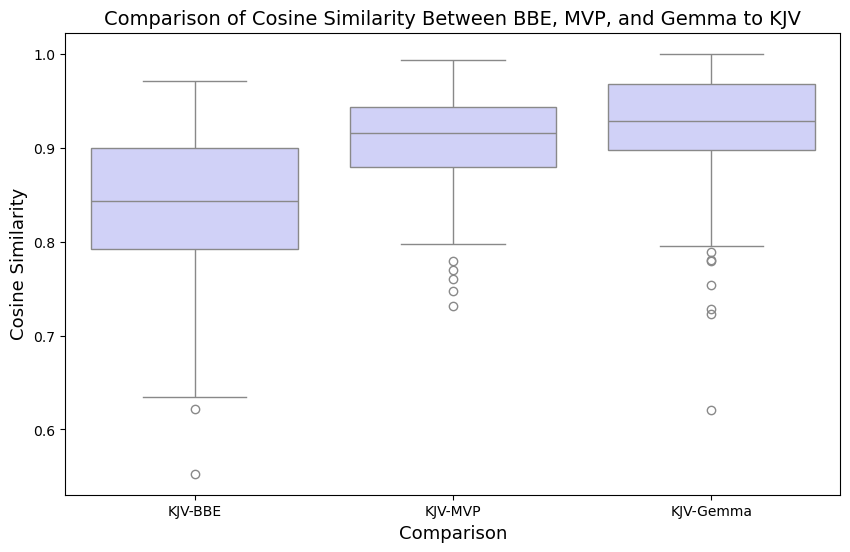

In [18]:
boxplot_data = pd.DataFrame({
    'Cosine Similarity': [
        *bible_df['cosine_kjv_bbe'],
        *bible_df['cosine_kjv_mvp'],
        *bible_df['cosine_kjv_gemma']
    ],
    'Comparison': [
        *(['KJV-BBE'] * len(bible_df['cosine_kjv_bbe'])),
        *(['KJV-MVP'] * len(bible_df['cosine_kjv_mvp'])),
        *(['KJV-Gemma'] * len(bible_df['cosine_kjv_gemma']))
    ]
})
color = "#C9CBFE"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Comparison', y='Cosine Similarity', data=boxplot_data, hue='Comparison', palette=[color] * 3, legend=False)

plt.title("Comparison of Cosine Similarity Between BBE, MVP, and Gemma to KJV", fontsize=14)
plt.xlabel("Comparison", fontsize=13)
plt.ylabel("Cosine Similarity", fontsize=13)

plt.show()

#### From the boxplot, it seems that MVP/Gemma tend to have greater semantic similarity to KJV than BBE to KJV. Furthermore, MVP and Gemma to KJV show less variance in semantic similarity than BBE to KJV. 


### Based on summary statistics alone, we see that KJV & MVP and KJV & Gemma seem to be more semantically similar than KJV & BBE

#### But let's statistically test this!

### First let's check normality to determine whether to use a parametric or non parametric test

In [10]:
def check_normality(data):
    test_result = stats.shapiro(data)
    return test_result  # Returns a tuple with (test statistic, p-value)

shapiro_kjv_bbe = check_normality(bible_df['cosine_kjv_bbe'])
shapiro_kjv_mvp = check_normality(bible_df['cosine_kjv_mvp'])
shapiro_kjv_gemma = check_normality(bible_df['cosine_kjv_gemma'])

print("Shapiro-Wilk Test for KJV-BBE cosine similarity:", shapiro_kjv_bbe)
print("Shapiro-Wilk Test for KJV-MVP cosine similarity:", shapiro_kjv_mvp)
print("Shapiro-Wilk Test for KJV-Gemma cosine similarity:", shapiro_kjv_gemma)

Shapiro-Wilk Test for KJV-BBE cosine similarity: ShapiroResult(statistic=0.9406619668006897, pvalue=0.0012336644576862454)
Shapiro-Wilk Test for KJV-MVP cosine similarity: ShapiroResult(statistic=0.9190889596939087, pvalue=0.00010535708861425519)
Shapiro-Wilk Test for KJV-Gemma cosine similarity: ShapiroResult(statistic=0.8677210211753845, pvalue=8.706378480383137e-07)


#### None of them are normally distributed 

### Use Wilcoxon Signed-Rank Test, a non-parametric test

In [11]:
wilcoxon_test_mvp = stats.wilcoxon(
    bible_df['cosine_kjv_mvp'],
    bible_df['cosine_kjv_bbe'],
    alternative='greater' #checks whether the cosine similarity between KJV-to-MVP is greater than that between KJV-to-BBE
)

# Wilcoxon Signed-Rank Test for KJV-to-Gemma and KJV-to-BBE
wilcoxon_test_gemma = stats.wilcoxon(
    bible_df['cosine_kjv_gemma'],
    bible_df['cosine_kjv_bbe'],
    alternative='greater' #checks whether the cosine similarity between KJV-to-Gemma is greater than that between KJV-to-BBE
)

print("Wilcoxon Test for KJV-to-MVP vs. KJV-to-BBE:")
print(wilcoxon_test_mvp)

print("Wilcoxon Test for KJV-to-Gemma vs. KJV-to-BBE:")
print(wilcoxon_test_gemma)

Wilcoxon Test for KJV-to-MVP vs. KJV-to-BBE:
WilcoxonResult(statistic=2843.0, pvalue=4.365646395691516e-11)
Wilcoxon Test for KJV-to-Gemma vs. KJV-to-BBE:
WilcoxonResult(statistic=2859.0, pvalue=2.5648515990305485e-11)


#### These results suggest that the cosine similarity between KJV and MVP/Gemma is greater than the cosine similarity between KJV and BBE. This supports my hypothesis, indicating that MVP and Gemma can generate text with at least as much semantic similarity to KJV as BBE and the models maintain semantic fidelity. 